# Problem Statement

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

# Importing Required Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler,Normalizer,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_validate,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, chi2, SelectFromModel,mutual_info_classif
from sklearn.feature_selection import VarianceThreshold, RFE
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb

# Loading Training and Test Dataset

In [2]:
train=pd.read_csv('Datasets\\Titanic\\train.csv')
test=pd.read_csv('Datasets\\Titanic\\test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


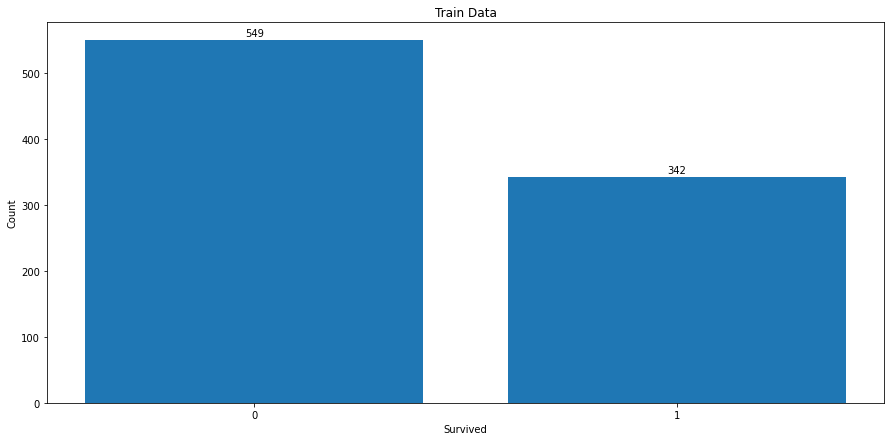

In [5]:
fig,ax=plt.subplots(figsize=(15,7))
ax.bar(train.Survived.value_counts().index,train.Survived.value_counts().values)
ax.set_xlabel('Survived')
ax.set_ylabel('Count')
ax.set_title('Train Data')
ax.set_xticks([0,1])
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

# Data Cleaning

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train.Cabin.value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
              ..
B73            1
A20            1
C91            1
T              1
C103           1
Name: Cabin, Length: 147, dtype: int64

In [12]:
print('Pclass 1 - ',train.loc[(train.Pclass==1) & (train.Cabin.isnull()==False),'Cabin'].unique())
print('Pclass 2 - ',train.loc[(train.Pclass==2) & (train.Cabin.isnull()==False),'Cabin'].unique())
print('Pclass 3 - ',train.loc[(train.Pclass==3) & (train.Cabin.isnull()==False),'Cabin'].unique())

Pclass 1 -  ['C85' 'C123' 'E46' 'C103' 'A6' 'C23 C25 C27' 'B78' 'D33' 'B30' 'C52'
 'B28' 'C83' 'E31' 'A5' 'D10 D12' 'D26' 'C110' 'B58 B60' 'D47' 'B86' 'C2'
 'E33' 'B19' 'A7' 'C49' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78'
 'D35' 'C87' 'B77' 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49'
 'C22 C26' 'C106' 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32'
 'B18' 'C124' 'C91' 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98'
 'E44' 'A34' 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30'
 'D20' 'B79' 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16'
 'C101' 'C68' 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26'
 'D48' 'E58' 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'C62 C64' 'E24'
 'C90' 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'D11' 'B3' 'D6' 'B82 B84' 'D17'
 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50' 'B42' 'C148']
Pclass 2 -  ['D56' 'F33' 'E101' 'F2' 'F4' 'D' 'E77']
Pclass 3 -  ['G6' 'F G73' 'F E69' 'E10' 'F G63' 'E121' 'F38']


In [13]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [14]:
print('Pclass 1 - ',train.loc[(train.Pclass==1) & (train.Embarked.isnull()==False),'Embarked'].unique())
print('Pclass 2 - ',train.loc[(train.Pclass==2) & (train.Embarked.isnull()==False),'Embarked'].unique())
print('Pclass 3 - ',train.loc[(train.Pclass==3) & (train.Embarked.isnull()==False),'Embarked'].unique())

Pclass 1 -  ['C' 'S' 'Q']
Pclass 2 -  ['C' 'S' 'Q']
Pclass 3 -  ['S' 'Q' 'C']


In [15]:
train['Age']=train.Age.fillna(28) # Median Age (28)
train['Embarked']=train.Embarked.fillna('S') # Most Frequent Value (S)
train['Cabin']=train[['Cabin','Pclass']].apply(lambda x: 'G6' if (x['Pclass']==3) & (pd.isnull(x['Cabin'])) else 'D' 
                                               if (x['Pclass']==2) & (pd.isnull(x['Cabin'])) else 'C23 C25 C27'
                                               if (x['Pclass']==1) & (pd.isnull(x['Cabin'])) else x['Cabin'],axis=1) # Most Frequent value in each class

In [16]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [17]:
test['Fare'].fillna(test['Fare'].median(),inplace=True)

In [18]:
pd.DataFrame(test.Cabin.value_counts()).head(14)

,Cabin
B57 B59 B63 B66,3
C116,2
C89,2
F4,2
C31,2
E34,2
C55 C57,2
C23 C25 C27,2
C6,2
C80,2


In [19]:
print('Pclass 1 - ',test.loc[(test.Pclass==1) & (test.Cabin.isnull()==False),'Cabin'].unique())
print('Pclass 2 - ',test.loc[(test.Pclass==2) & (test.Cabin.isnull()==False),'Cabin'].unique())
print('Pclass 3 - ',test.loc[(test.Pclass==3) & (test.Cabin.isnull()==False),'Cabin'].unique())

Pclass 1 -  ['B45' 'E31' 'B57 B59 B63 B66' 'B36' 'A21' 'C78' 'D34' 'D19' 'A9' 'D15'
 'C31' 'C23 C25 C27' 'B61' 'C53' 'D43' 'C130' 'C132' 'C101' 'C55 C57'
 'B71' 'C46' 'C116' 'A29' 'C6' 'C28' 'C51' 'E46' 'C54' 'C97' 'D22' 'B10'
 'E45' 'E52' 'D30' 'B58 B60' 'E34' 'C62 C64' 'A11' 'B11' 'C80' 'C85' 'D37'
 'C86' 'D21' 'C89' 'A34' 'B26' 'C22 C26' 'B69' 'C32' 'B78' 'A18' 'C106'
 'B51 B53 B55' 'D10 D12' 'E60' 'E50' 'E39 E41' 'B52 B54 B56' 'C39' 'B24'
 'D28' 'B41' 'C7' 'D40' 'C105']
Pclass 2 -  ['F' 'F4' 'F33' 'D' 'F2' 'D38']
Pclass 3 -  ['F G63' 'G6' 'F E46' 'F E57']


In [20]:
test['Age']=test.Age.fillna(27) # Median Age (27)
test['Cabin']=test[['Cabin','Pclass']].apply(lambda x: 'G6' if (x['Pclass']==3) & (pd.isnull(x['Cabin'])) else 'F4' 
                                               if (x['Pclass']==2) & (pd.isnull(x['Cabin'])) else 'B57 B59 B63 B66'
                                               if (x['Pclass']==1) & (pd.isnull(x['Cabin'])) else x['Cabin'],axis=1) # Most Frequent value in each class

In [21]:
train['familySize']=train['Parch']+train['SibSp']+1
train['familyType']=train.familySize.apply(lambda x: 'Single' if x ==1 else 'Small Family' if x <5 else 'Large Family')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,familySize,familyType
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G6,S,2,Small Family
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,Small Family
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,G6,S,1,Single
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,Small Family
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,G6,S,1,Single


In [22]:
test['familySize']=test['Parch']+test['SibSp']+1
test['familyType']=test.familySize.apply(lambda x: 'Single' if x ==1 else 'Small Family' if x <5 else 'Large Family')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,familySize,familyType
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,G6,Q,1,Single
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,G6,S,2,Small Family
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,F4,Q,1,Single
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,G6,S,1,Single
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,G6,S,3,Small Family


In [23]:
train['Title']=train.Name.apply(lambda x: re.split('[,.]',x)[1].strip())
train['Title']=train['Title'].replace({'Capt':'Officer','Col':'Officer','Major':'Officer','Dr':'Officer','Rev':'Officer',
                       'Jonkheer':'Royalty','Don':'Royalty','Sir':'Royalty','the Countess':'Royalty','Lady':'Royalty',
                        'Mme':'Mrs','Mlle':'Miss','Ms':'Mrs'})
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,familySize,familyType,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G6,S,2,Small Family,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,Small Family,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,G6,S,1,Single,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,Small Family,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,G6,S,1,Single,Mr


In [24]:
test['Title']=test.Name.apply(lambda x: re.split('[,.]',x)[1].strip())
test['Title']=test['Title'].replace({'Capt':'Officer','Col':'Officer','Major':'Officer','Dr':'Officer','Rev':'Officer',
                       'Jonkheer':'Royalty','Don':'Royalty','Sir':'Royalty','the Countess':'Royalty','Lady':'Royalty',
                        'Mme':'Mrs','Mlle':'Miss','Ms':'Mrs','Dona':'Royalty'})
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,familySize,familyType,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,G6,Q,1,Single,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,G6,S,2,Small Family,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,F4,Q,1,Single,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,G6,S,1,Single,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,G6,S,3,Small Family,Mrs


In [25]:
train['Age']=round(train['Age'],0)
train['Age']=train['Age'].astype('int64')
train['Age_Bucket']=train.Age.apply(lambda x:0 if x<=20 else 1 if (x>20) & (x<=40)
                                    else 2 if (x>40) & (x<=60) else 3)
test['Age_Bucket']=test.Age.apply(lambda x:0 if x<=20 else 1 if (x>20) & (x<=40)
                                    else 2 if (x>40) & (x<=60) else 3)
train['LastName']=train.Name.apply(lambda x:re.split(',',x)[0])
test['LastName']=test.Name.apply(lambda x:re.split(',',x)[0])
train['fareperperson']=train[['Fare','familySize']].apply(lambda x: x['Fare']/x['familySize'],axis=1)
test['fareperperson']=test[['Fare','familySize']].apply(lambda x: x['Fare']/x['familySize'],axis=1)

# Exploratory Data Analysis

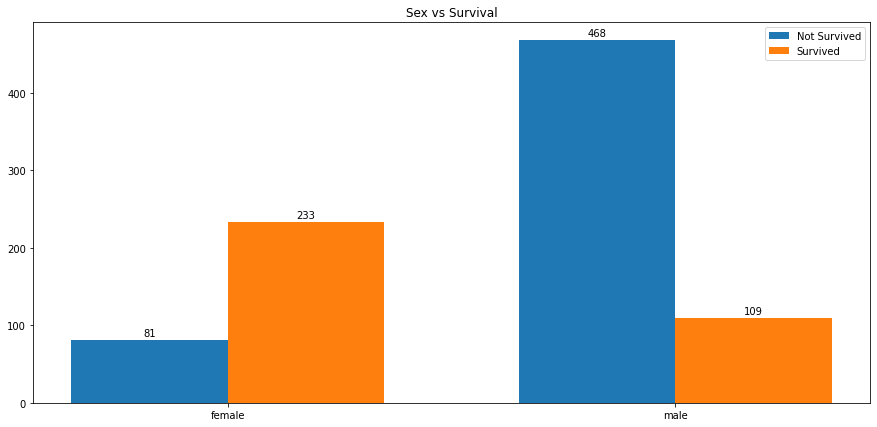

In [26]:
survival_based_on_sex=pd.DataFrame(train.groupby(['Survived','Sex']).count()['PassengerId'])
width=.35
x=np.arange(len(survival_based_on_sex.loc[0].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in survival_based_on_sex.loc[0].PassengerId], width, label='Not Survived')
rects2 = ax.bar(x + width/2, [i for i in survival_based_on_sex.loc[1].PassengerId], width, label='Survived')
ax.set_xticks(x)
ax.set_xticklabels(survival_based_on_sex.loc[0].index)
ax.legend()
ax.set_title('Sex vs Survival')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

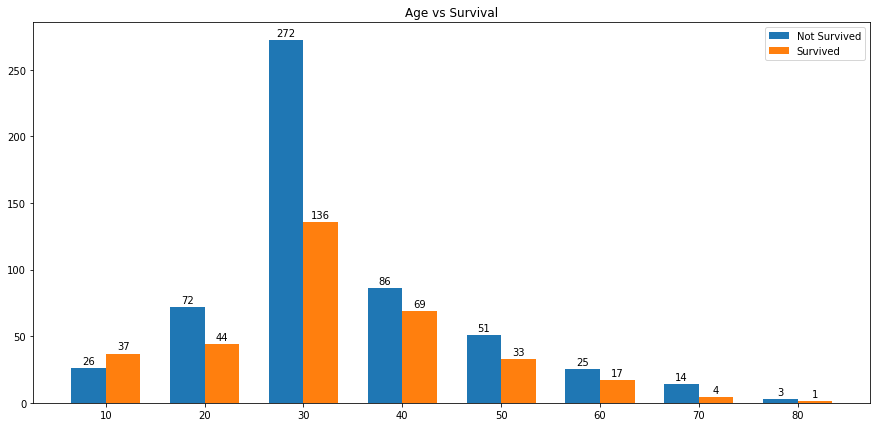

In [27]:
bins = [0,10,20,30,40,50,60,70,80]
groups = train.groupby(['Survived',pd.cut(train.Age, bins)])
group=groups.PassengerId.count()

width=.35
x=np.arange(8)
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, group.loc[0].values, width, label='Not Survived')
rects2 = ax.bar(x + width/2, group.loc[1].values, width, label='Survived')
ax.set_xticks(x)
ax.set_xticklabels([10,20,30,40,50,60,70,80])
ax.legend()
ax.set_title('Age vs Survival')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

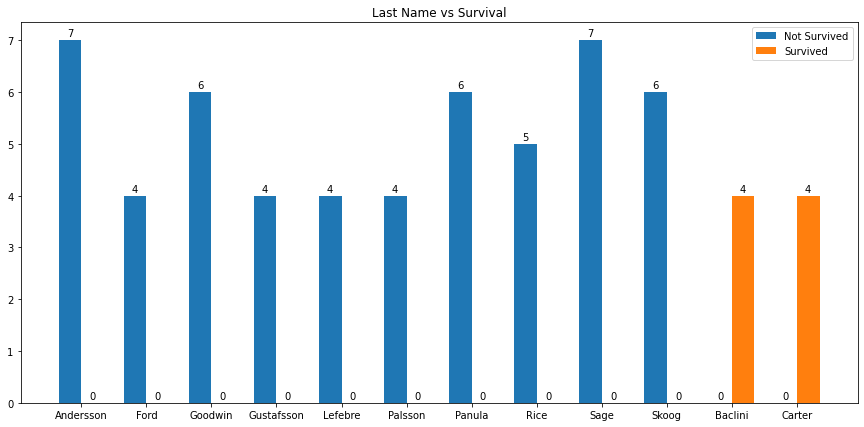

In [28]:
survival_based_on_lastname=pd.DataFrame(train.groupby(['Survived','LastName']).count()['PassengerId'])
survival_based_on_lastname=survival_based_on_lastname.loc[survival_based_on_lastname.PassengerId>3]
survival_based_on_lastname=survival_based_on_lastname.reindex(
    pd.MultiIndex.from_product([survival_based_on_lastname.index.get_level_values(0).unique(),
                               survival_based_on_lastname.index.get_level_values(1).unique()],
                              names=['Survived','LastName'])).fillna(0)
width=.35
x=np.arange(len(survival_based_on_lastname.loc[0].index))
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, [i for i in survival_based_on_lastname.loc[0].PassengerId], width, label='Not Survived')
rects2 = ax.bar(x + width/2, [i for i in survival_based_on_lastname.loc[1].PassengerId], width, label='Survived')
ax.set_xticks(x)
ax.set_xticklabels(survival_based_on_lastname.loc[0].index)
ax.legend()
ax.set_title('Last Name vs Survival')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

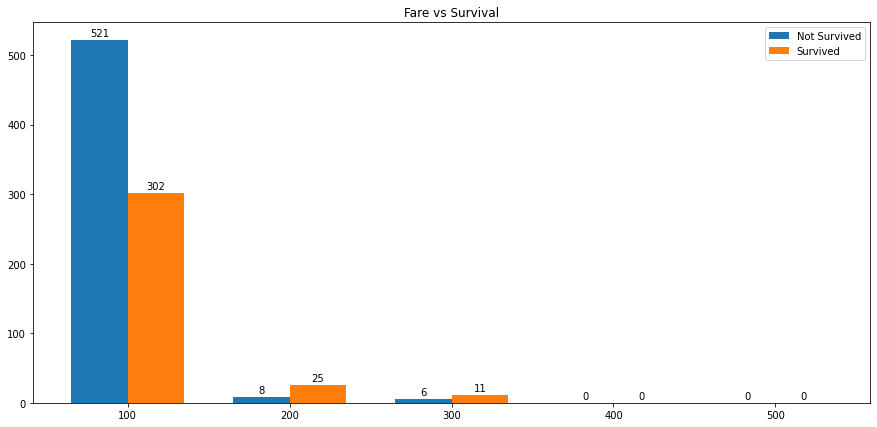

In [29]:
bins = [0,100,200,300,400,500]
groups = train.groupby(['Survived',pd.cut(train.Fare, bins)])
group=groups.PassengerId.count()

width=.35
x=np.arange(5)
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, group.loc[0].values, width, label='Not Survived')
rects2 = ax.bar(x + width/2, group.loc[1].values, width, label='Survived')
ax.set_xticks(x)
ax.set_xticklabels([100,200,300,400,500])
ax.legend()
ax.set_title('Fare vs Survival')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

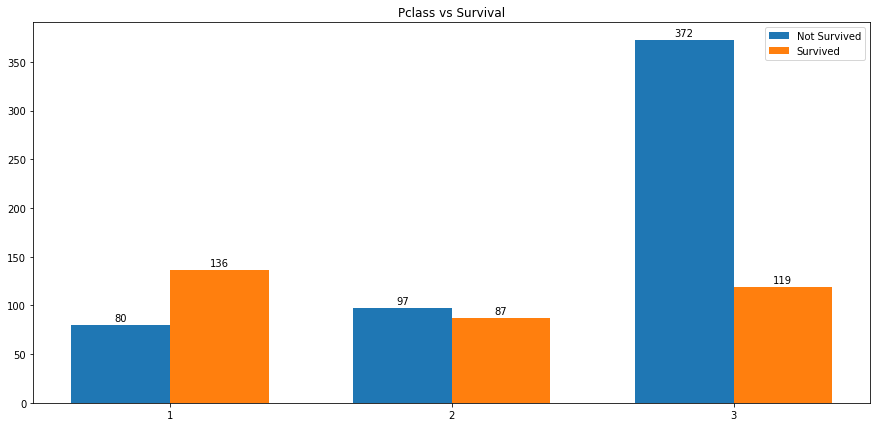

In [30]:
groups = train.groupby(['Survived','Pclass'])
group=groups.PassengerId.count()

width=.35
x=np.arange(3)
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, group.loc[0].values, width, label='Not Survived')
rects2 = ax.bar(x + width/2, group.loc[1].values, width, label='Survived')
ax.set_xticks(x)
ax.set_xticklabels([1,2,3])
ax.legend()
ax.set_title('Pclass vs Survival')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

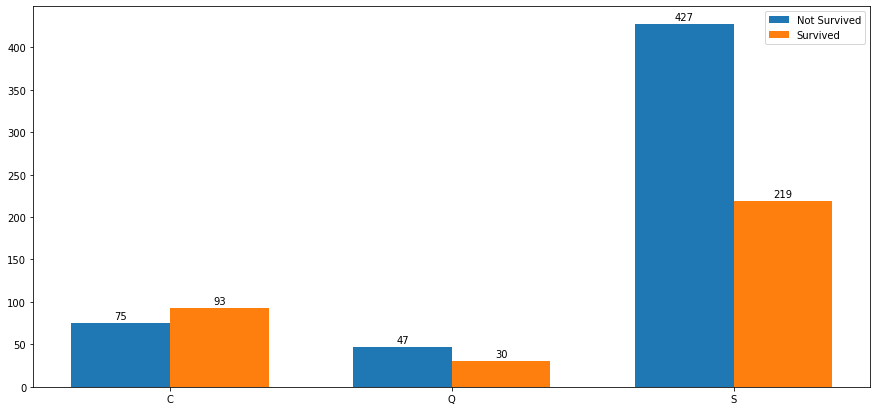

In [31]:
groups = train.groupby(['Survived','Embarked'])
group=groups.PassengerId.count()

width=.35
x=np.arange(3)
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, group.loc[0].values, width, label='Not Survived')
rects2 = ax.bar(x + width/2, group.loc[1].values, width, label='Survived')
ax.set_xticks(x)
ax.set_xticklabels(['C','Q','S'])
ax.legend()
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

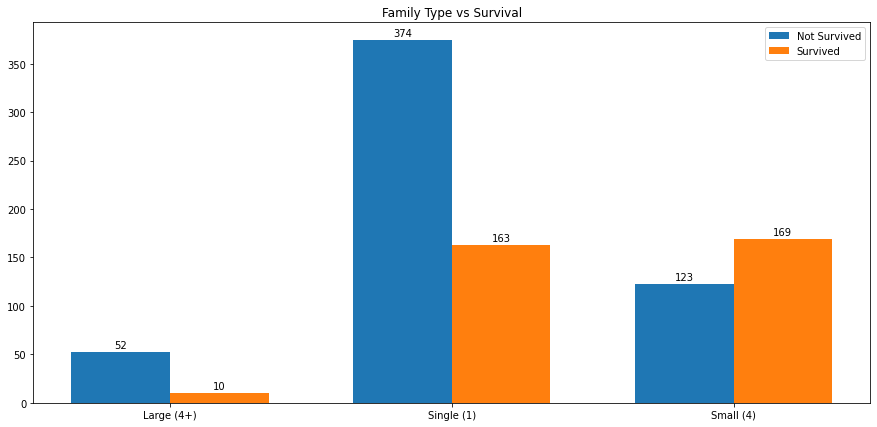

In [32]:
groups = train.groupby(['Survived','familyType'])
group=groups.PassengerId.count()

width=.35
x=np.arange(3)
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, group.loc[0].values, width, label='Not Survived')
rects2 = ax.bar(x + width/2, group.loc[1].values, width, label='Survived')
ax.set_xticks(x)
ax.set_xticklabels(['Large (4+)','Single (1)','Small (4)'])
ax.legend()
ax.set_title('Family Type vs Survival')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

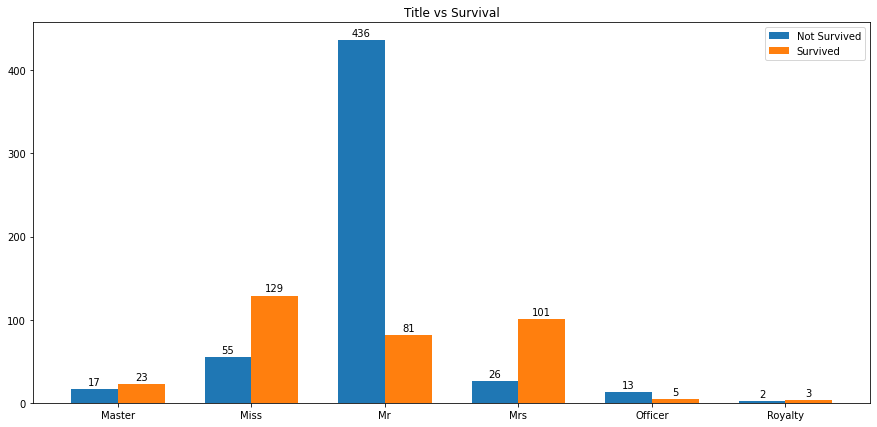

In [33]:
groups = train.groupby(['Survived','Title'])
group=groups.PassengerId.count()

width=.35
x=np.arange(6)
fig,ax=plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, group.loc[0].values, width, label='Not Survived')
rects2 = ax.bar(x + width/2, group.loc[1].values, width, label='Survived')
ax.set_xticks(x)
ax.set_xticklabels(['Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Royalty'])
ax.legend()
ax.set_title('Title vs Survival')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

<AxesSubplot:>

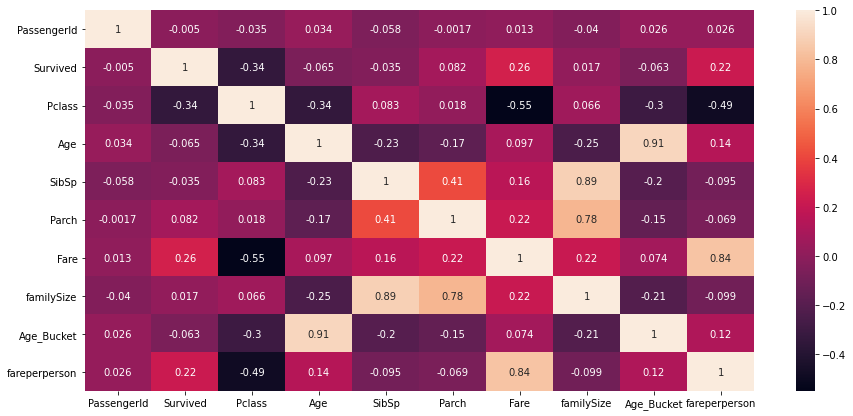

In [34]:
cor_mat=train.corr()
fig,ax=plt.subplots(figsize=(15,7))
sns.heatmap(cor_mat,annot=True)

# Model Selection

In [35]:
drop=['PassengerId','Survived','Name','Ticket','LastName','fareperperson','Age_Bucket']
x=train[[x for x in train.columns if x not in drop]]
y=train[['Survived']]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,random_state=1)

In [36]:
xx=test[[x for x in test.columns if x not in drop]]

In [37]:
ct=ColumnTransformer([('ohe',OneHotEncoder(sparse=False, handle_unknown='ignore'),
                       ['Sex', 'Cabin', 'Embarked', 'familyType', 'Title'])],remainder='passthrough')


In [38]:
models=[LogisticRegression(random_state=1),LinearDiscriminantAnalysis(),LinearSVC(random_state=1),SVC(random_state=1),
        RandomForestClassifier(random_state=1),BaggingClassifier(random_state=1),
        DecisionTreeClassifier(random_state=1),KNeighborsClassifier(),xgb.XGBClassifier()]
scales=[RobustScaler(),StandardScaler(),Normalizer(),MinMaxScaler()]
result=[]
for model in models:
    final=[]
    for scale in scales:
        pipe=Pipeline([('ct',ct),('scale',scale),('model',model)])
        score=cross_val_score(estimator=pipe,X=x,y=np.array(y).ravel(),cv=5,n_jobs=-1,scoring='f1').mean()
        final.append(round(score*100,2))
    result.append(final)
base_result=pd.DataFrame(result,index=['Logistic Regression','LDA','LSVC','SVC','RFC','Bagging','Decision Tree','KNN','XGB'],
             columns=['Robust Scaler','Standard Scaler','Normalizer','Min Max Scaler'])
base_result

,Robust Scaler,Standard Scaler,Normalizer,Min Max Scaler
Logistic Regression,77.12,76.69,54.05,77.00
LDA,77.29,77.29,73.35,77.29
LSVC,78.12,77.64,62.86,77.70
SVC,76.79,75.98,53.72,75.64
RFC,73.68,73.38,72.15,73.60
Bagging,73.75,73.87,72.95,73.68
Decision Tree,71.27,71.94,69.31,71.73
KNN,74.06,72.39,65.52,73.28
XGB,76.51,76.40,73.48,76.51


#### Hyper Parameter Tuning 

In [39]:
pipe=Pipeline([('ct-step',ct),('scale',RobustScaler()),('model',LinearSVC(max_iter=1000,random_state=1))])
params={'model__tol':[0.0001,0.001,0.01,.1,.2],'model__penalty':['l1', 'l2'],'model__C' : np.logspace(-4, 4, 20)}
grid=GridSearchCV(estimator=pipe,param_grid=params,scoring='accuracy',cv=5,n_jobs=-1).fit(x,y=np.array(y).ravel())
print(grid.best_score_)
print(grid.best_params_)

0.8383654510074697
{'model__C': 0.615848211066026, 'model__penalty': 'l2', 'model__tol': 0.1}


In [40]:
pipe=Pipeline([('ct-step',ct),('scale',RobustScaler()),('model',LinearSVC(max_iter=1000,C=0.615848211066026,
                                                                          penalty='l2',tol=0.1,random_state=1))])
pipe.fit(x_train,np.array(y_train).ravel())
y_pred=pipe.predict(X=x_test)
metrics_df=pd.DataFrame(data=[metrics.f1_score(y_test,y_pred),metrics.precision_score(y_test,y_pred),
                              metrics.recall_score(y_test,y_pred),metrics.accuracy_score(y_test,y_pred)],
                        index=['F1 Score','Precision','Recall','Accuracy'],
                        columns=['Score'])
metrics_df

,Score
F1 Score,0.760563
Precision,0.826531
Recall,0.704348
Accuracy,0.809701


Text(0.5, 1.0, 'Confusion Matrix')

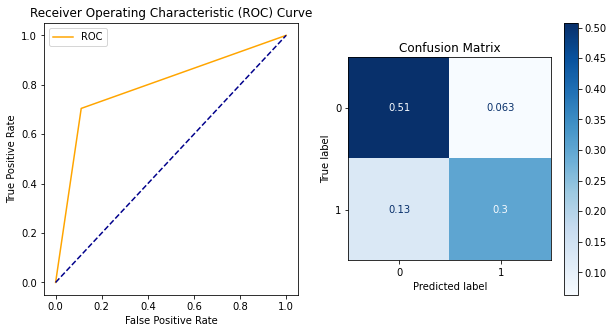

In [41]:
fper, tper, thresholds = metrics.roc_curve(y_test, y_pred)
fig,ax=plt.subplots(figsize=(10,5),nrows=1,ncols=2)
ax[0].plot(fper, tper, color='orange', label='ROC')
ax[0].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend()
metrics.plot_confusion_matrix(pipe, x_test, y_test,cmap=plt.cm.Blues, normalize = 'all',ax=ax[1])
ax[1].set_title('Confusion Matrix')

In [42]:
pipe=Pipeline([('ct-step',ct),('model',LinearSVC(max_iter=1000,C=0.615848211066026,penalty='l2',tol=0.1,random_state=1))])
pipe.fit(x,np.array(y).ravel())
y_pred=pipe.predict(X=xx)
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [43]:
submission=test.join(pd.DataFrame(y_pred,columns=['Survived']))

In [44]:
# submission=submission[['PassengerId','Survived']]
# submission.to_csv('Submission.csv',index=False)